# Testing KNN, SVM and Logistic  Models


---


---


In [ ]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

filterwarnings('ignore')

In [ ]:
#Reading the database and checking some information
#I purposely eliminated some information from the data set so that I could apply methods to fill
#in empty fields and transform text data into numeric values.

Dataset = pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')
Dataset.info()
Dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              565 non-null    float64
 1   mean texture             566 non-null    float64
 2   mean perimeter           566 non-null    float64
 3   mean area                568 non-null    float64
 4   mean smoothness          566 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,565.000000,566.000000,566.000000,568.000000,566.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,711.656867,19.291343,91.869399,654.637500,0.096259,0.104341,0.088799,0.048919,0.181162,0.062798,...,315.194921,25.677223,107.261213,880.583128,0.132369,2.111808,4.410401,0.114606,0.290076,0.083946
std,2438.148614,4.309063,24.290511,352.173096,0.013926,0.052813,0.079720,0.038803,0.027414,0.007060,...,1655.459336,6.146258,33.602542,569.356993,0.022832,44.343334,69.928599,0.065732,0.061867,0.018061
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,12.200000,16.172500,75.065000,420.175000,0.086380,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.180000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.850000,18.835000,86.140000,548.750000,0.095865,0.092630,0.061540,0.033500,0.179200,0.061540,...,15.150000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,17.600000,21.807500,104.025000,782.625000,0.105250,0.130400,0.130700,0.074000,0.195700,0.066120,...,19.850000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9904.000000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,9981.000000,49.540000,251.200000,4254.000000,0.222600,1058.000000,1252.000000,0.291000,0.663800,0.207500


# Checking Some Measurements

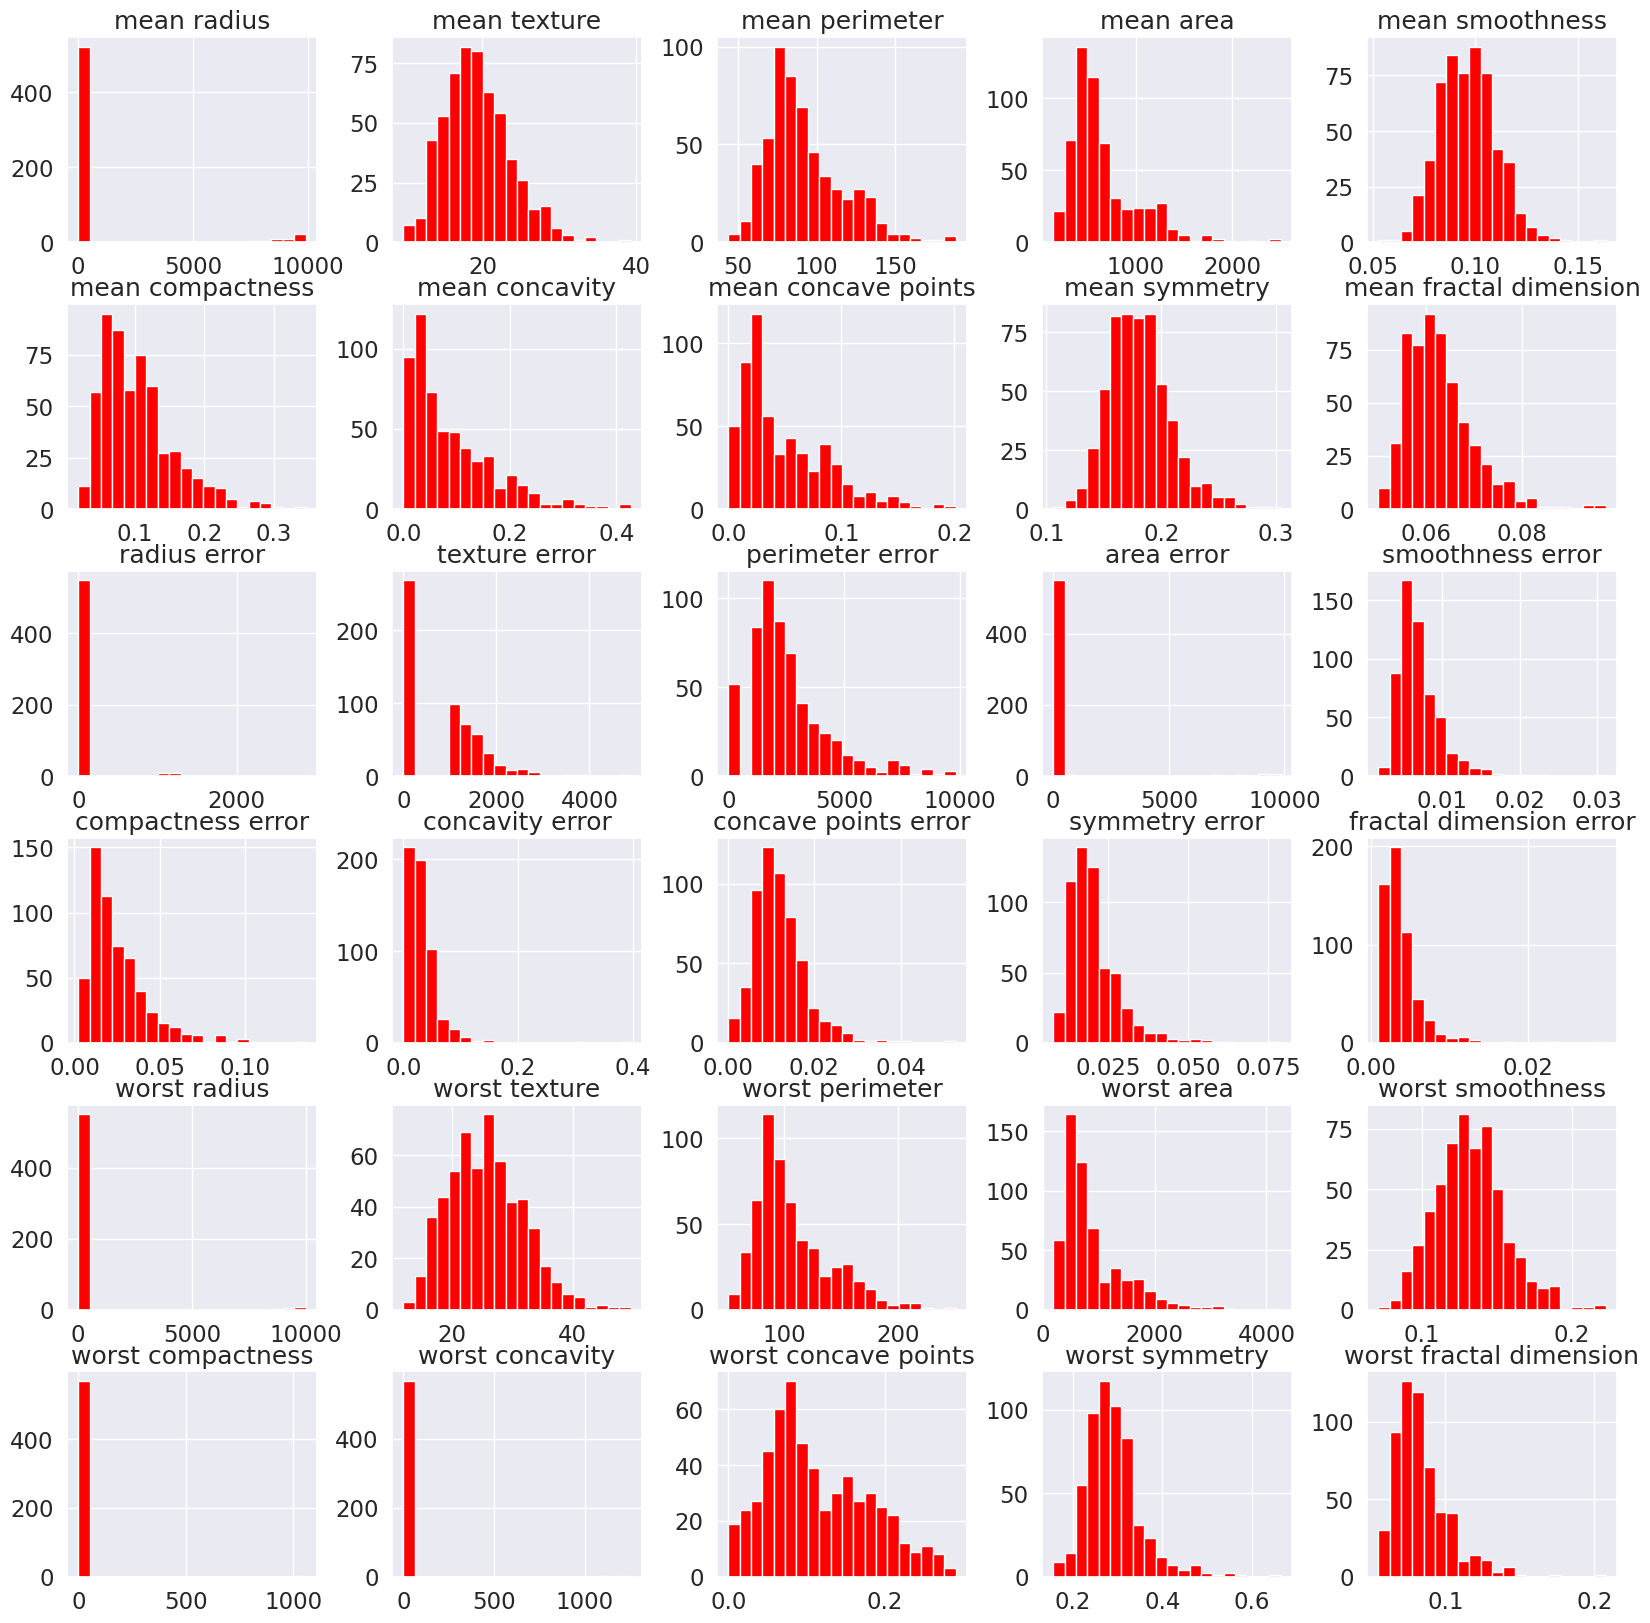

In [ ]:

#Check some distributions
sns.set(font_scale=1.5,rc={'figure.figsize':(20,20)})
eixo=Dataset.hist(bins=20,color='red')

<Axes: >

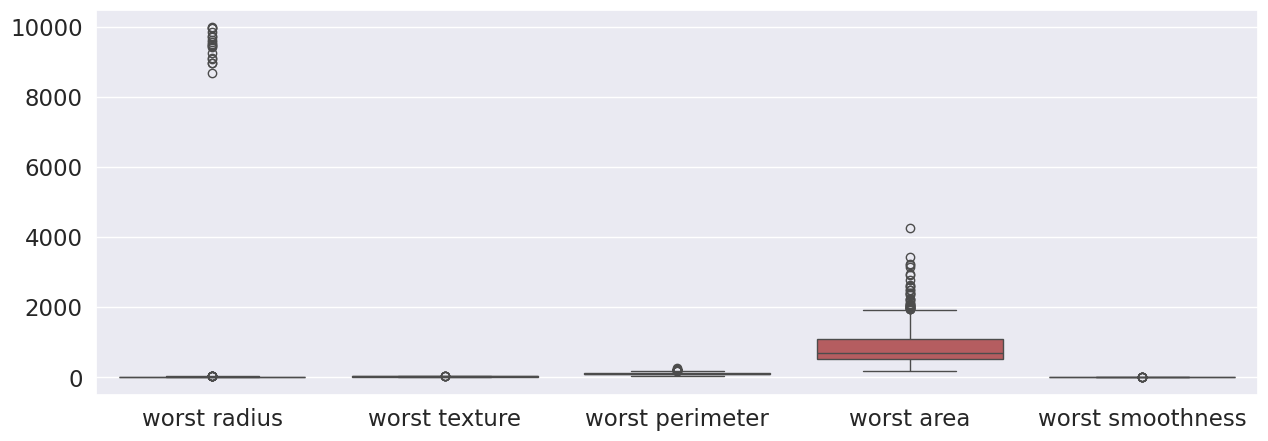

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=Dataset.iloc[:, 20:25])

# Processing Some Variables

In [ ]:
# select objetc columns and transform into float values
def float_values(base,textos):
   #textos =base.select_dtypes(include=['object']).columns
   for column in textos:
    if column not in ['target','Family Case']:
      base[column] = base[column].str.replace(',', '.').astype(float)
   base.select_dtypes(include=['object']).columns
   return base

#if my target is a text I transform in dummy value
def target_variable(base):
  base['target'] = np.where(base['target']=='Malignant', 1, 0)
  return base

# transform in dummies some variables
def dummy_df(base, X,c):
    Lista_variaveis = []
    Lista_dummies = []

    objetos = []
    for column_name in base.columns:
        if column_name in c:
            objetos.append(column_name)

    if objetos:  # Check if objetos is not empty
        # Convert X to a DataFrame for easier manipulation
        X_df = pd.DataFrame(X, columns=base.columns[:-1])

        # Perform one-hot encoding using Pandas get_dummies
        for col_name in objetos:
            # Get the numerical index of the column
            col_index = X_df.columns.get_loc(col_name)
            dummy_df = pd.get_dummies(X_df.iloc[:, col_index], prefix=base.columns[col_index], dtype='int')

            X_df = pd.concat([X_df, dummy_df], axis=1)
            Lista_dummies.extend(dummy_df.columns)  # Add dummy column names

        # Drop original categorical columns
        X_df = X_df.drop(columns=objetos)  # Pass column names directly

        # Update Lista_variaveis with dummy columns and remaining features
        Lista_variaveis = list(X_df.columns[~X_df.columns.isin(Lista_dummies)]) + Lista_dummies
        # Convert back to NumPy array if needed
        X = X_df.values
    return X, Lista_variaveis

def normalize_df(X,Lista_variaveis):
  #Normalize the data
  X =pd.DataFrame(data=X, columns=Lista_variaveis)
  min_max_scaler =MinMaxScaler()
  X = min_max_scaler.fit_transform(X)
  return X




In [ ]:
#In this step I select my data set and transform other text variables into numeric ones to facilitate the processing of my model.
textos =Dataset.select_dtypes(include=['object']).columns
c=list(textos)
c.remove('target')
Dataset=float_values(Dataset,textos)
Dataset=target_variable(Dataset)


X = Dataset.iloc[:,:-1].values
y = Dataset.iloc[:,-1].values

In [ ]:
#In this step I select my data set and transform other text variables into numeric ones to facilitate the processing of my model.
# Get the indices of columns with missing values
missing_cols_indices = [Dataset.columns.get_loc(col) for col in Dataset.columns[Dataset.isna().any()]]

# Impute missing values using these indices
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X[:, missing_cols_indices])
X[:, missing_cols_indices] = imputer.transform(X[:, missing_cols_indices])

In [ ]:
X,Lista_variaveis=dummy_df(Dataset,X,c)
X=normalize_df(X,Lista_variaveis)

<Axes: >

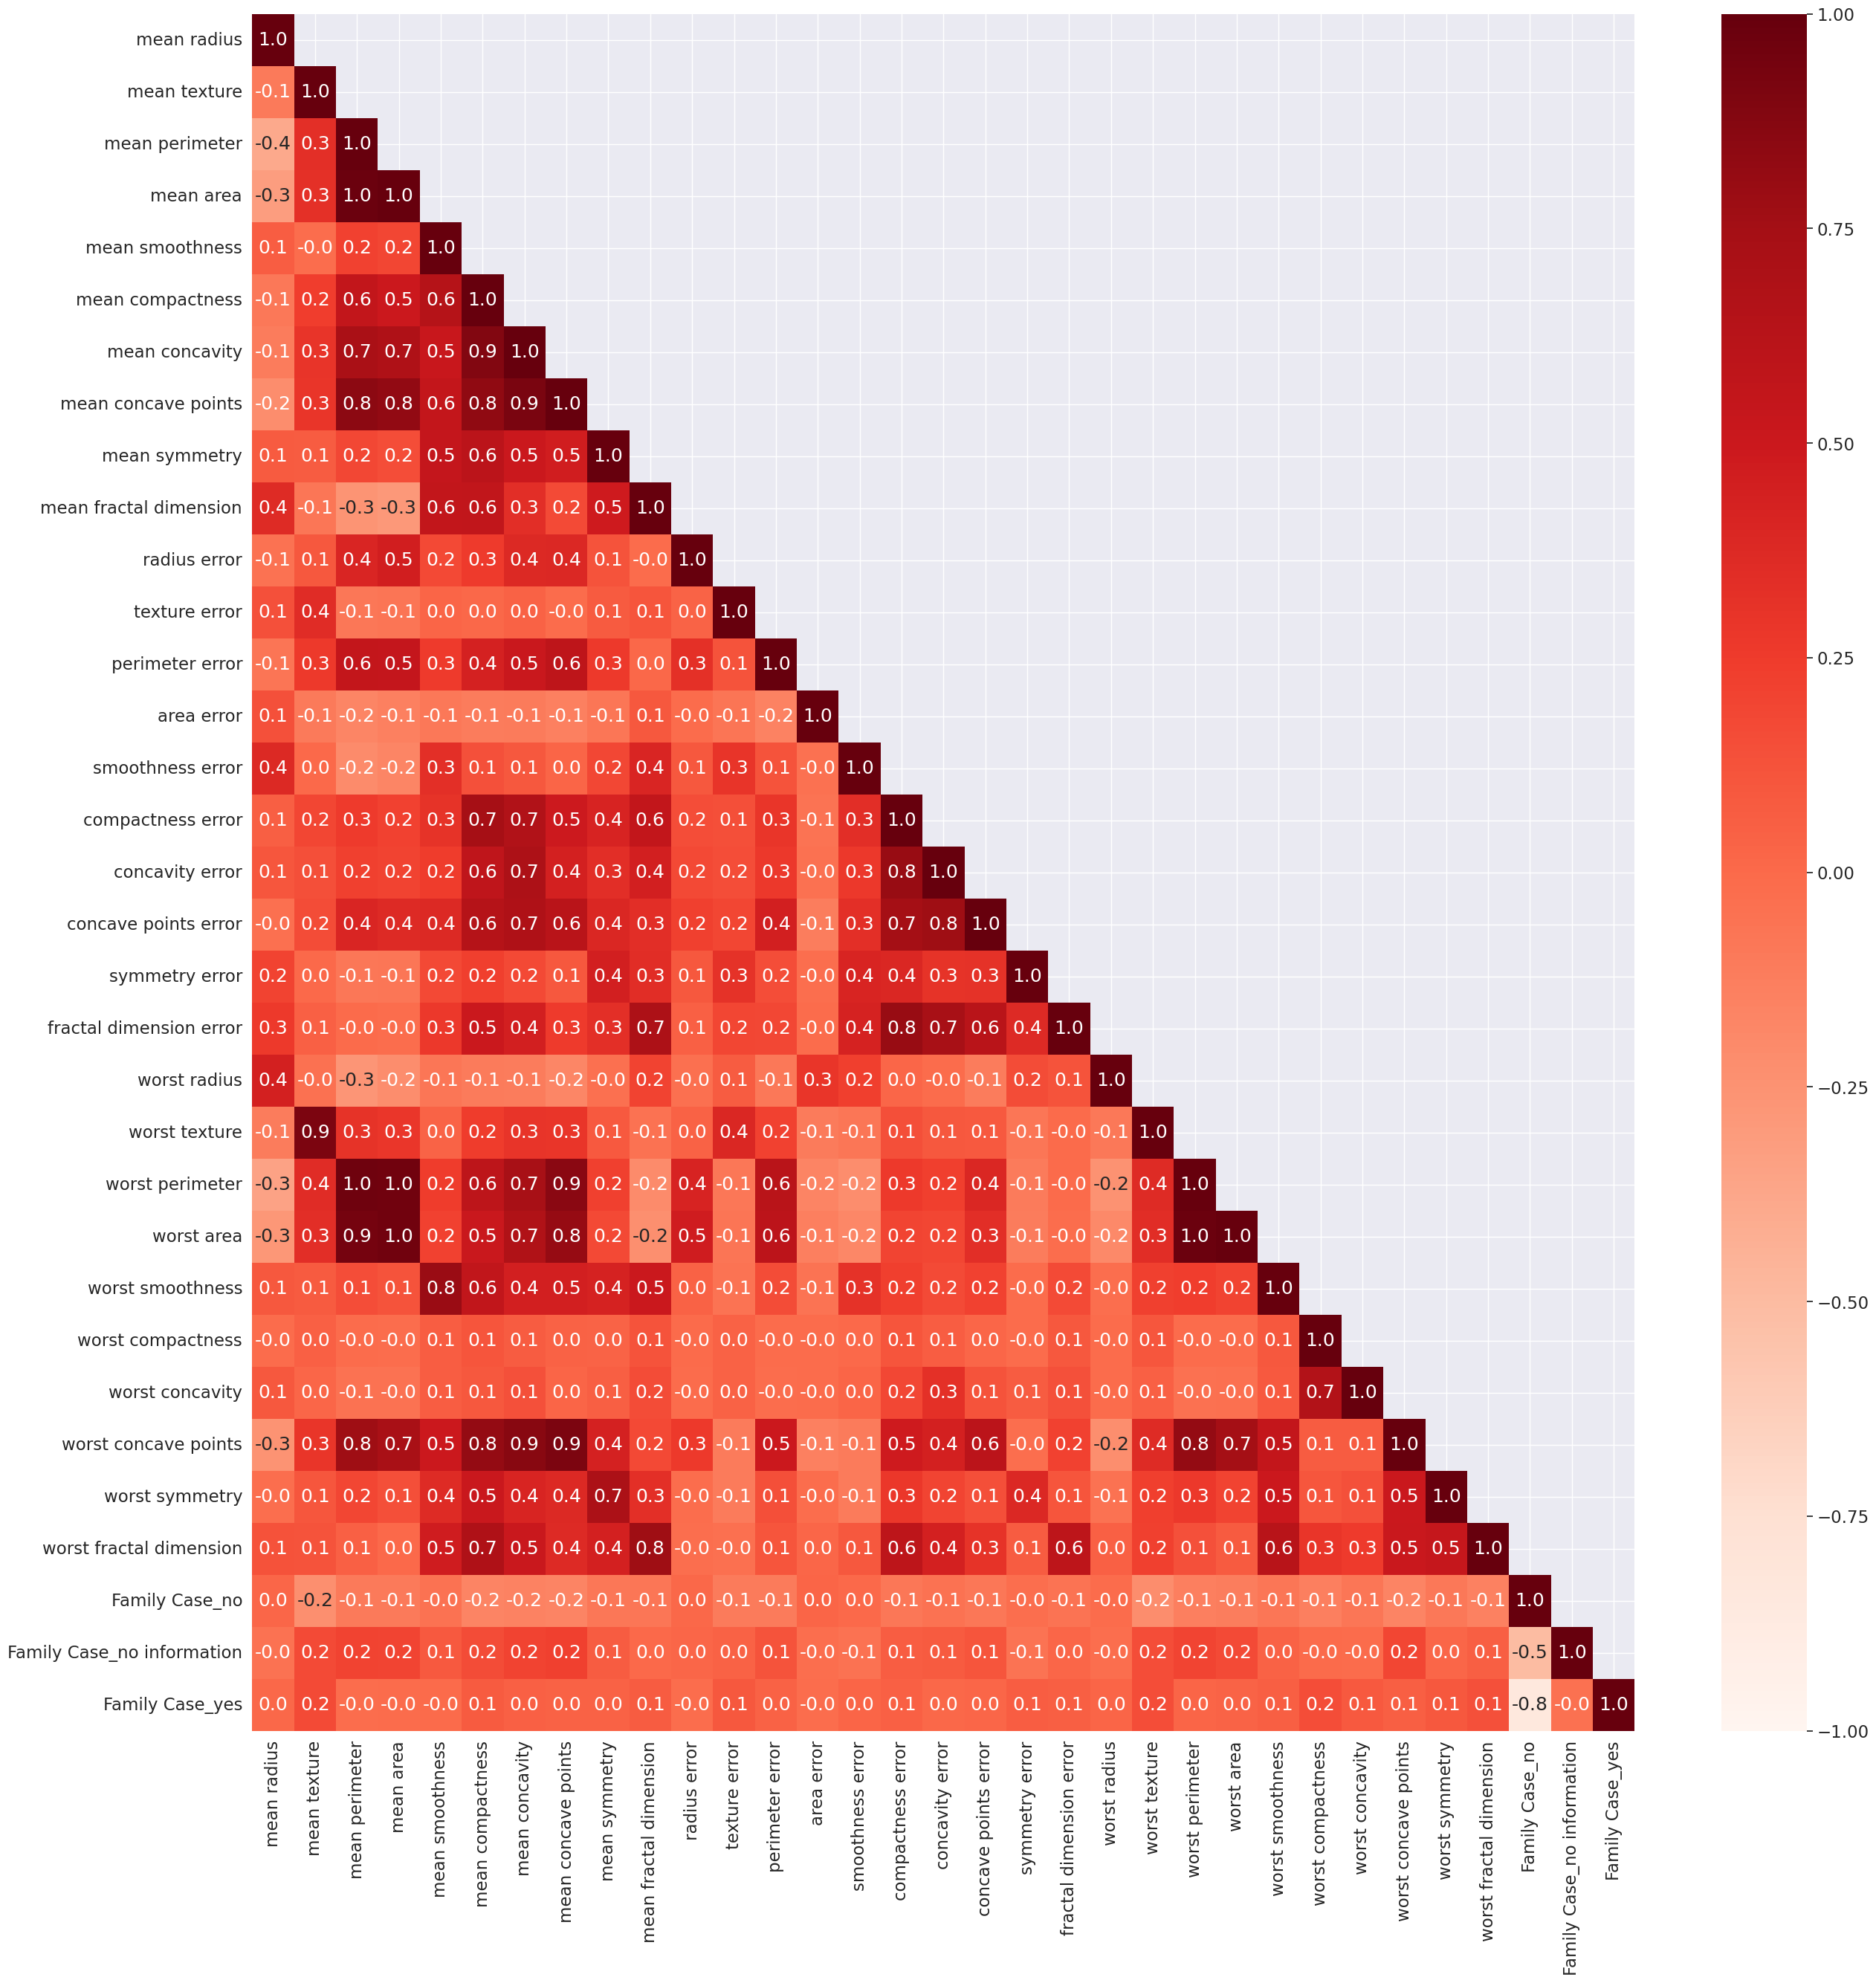

In [ ]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='Reds', vmin=-1, vmax=1,
            mask=mask)

<Axes: >

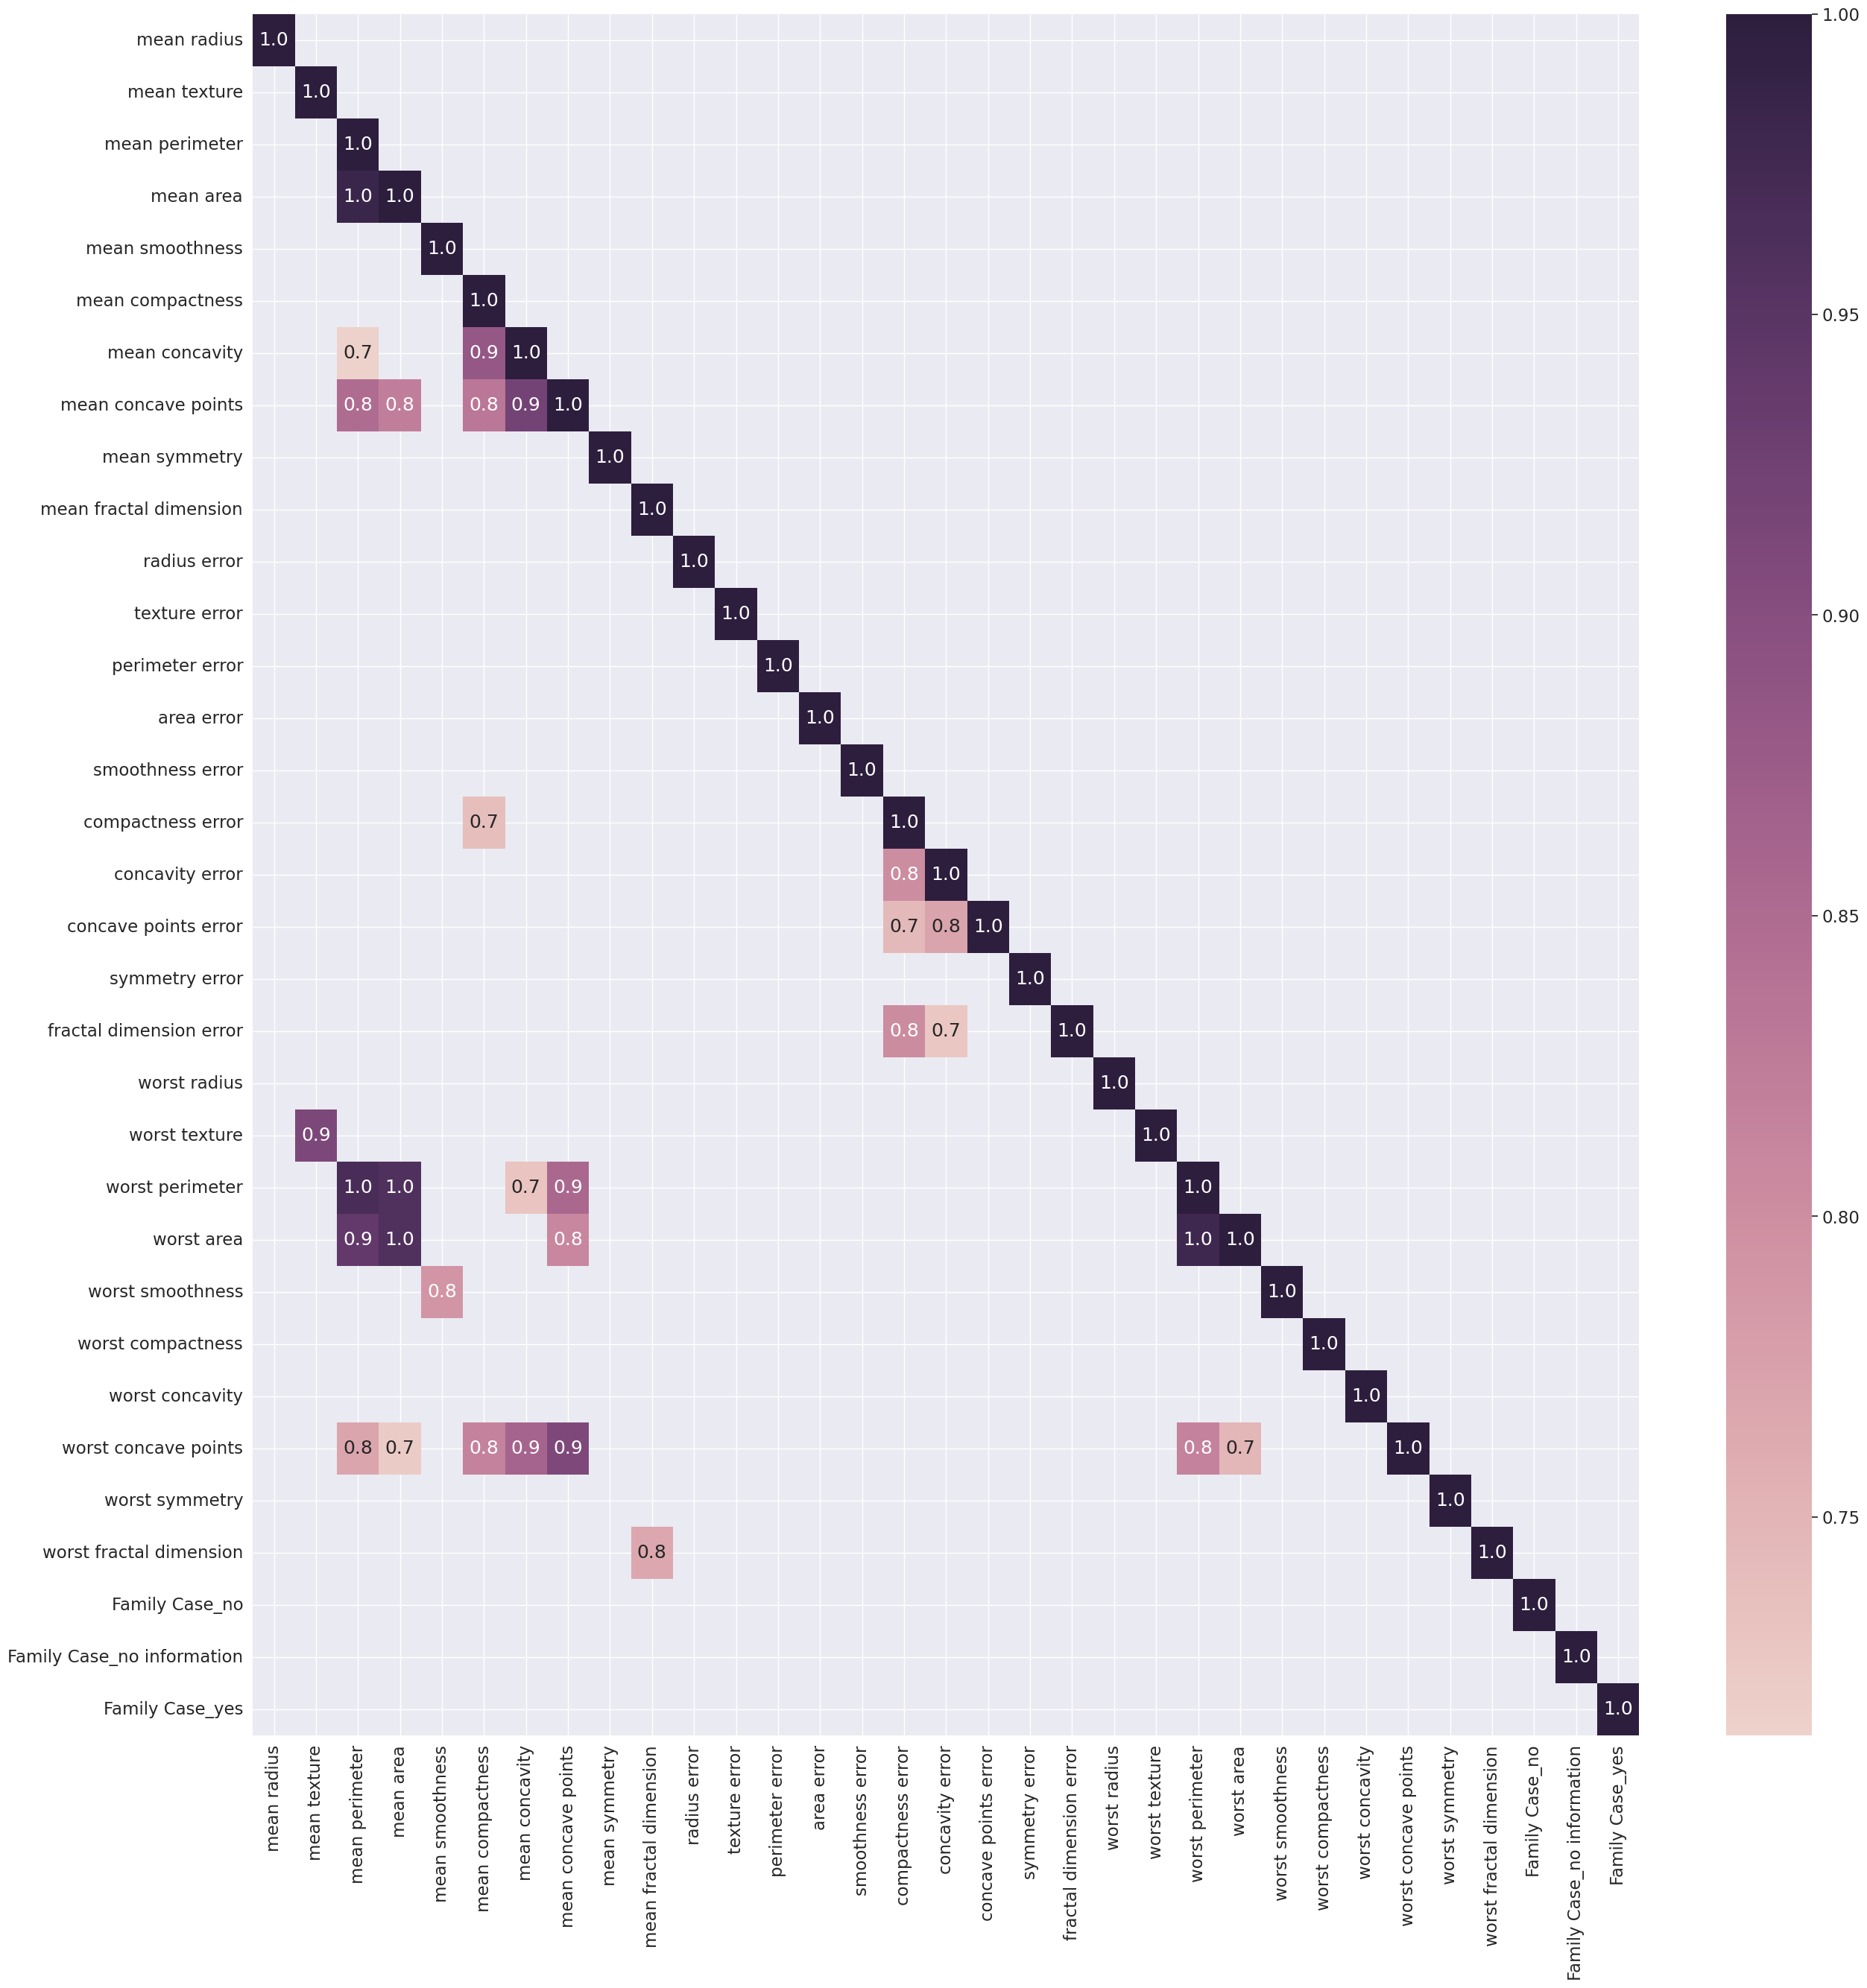

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200), mask=mask)

In [ ]:
def get_top_correlations_blog(df, threshold=-1):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. For eg, if this is -1.
    """
    orig_corr = df.corr()
    c = orig_corr.abs()

    so = c.unstack()

    #print("|    Variable 1    |    Variable 2    | Correlation Coefficient    |")
    #print("|------------------|------------------|----------------------------|")

    i=0
    pairs=set()
    result = pd.DataFrame()
    for index, value in so.sort_values(ascending=False).items():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:

            #print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            pairs.add((index[0], index[1]))
            i+=1
    return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])

get_top_correlations_blog(X_df)

,,Correlation Coefficient
Variable 1,Variable 2,
mean perimeter,mean area,0.98328
worst perimeter,worst area,0.977578
mean perimeter,worst perimeter,0.96835
mean area,worst area,0.959014
worst perimeter,mean area,0.958907
...,...,...
fractal dimension error,worst texture,-0.003195
mean smoothness,Family Case_yes,-0.002675
smoothness error,Family Case_no,0.002577


# Model Development and Results

In [ ]:
#Developing assessments for a model
def getAccuracy(confusionMatrix):
    accuracy = (confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[1][0] + confusionMatrix[0][1] + confusionMatrix[1][1])
    return accuracy * 100

def evaluateModel(yPred, yTest):
        confusionMatrix = confusion_matrix(yTest, yPred)

        return confusionMatrix

#GridSearchCV is a powerful tool for finding the best hyperparameters for
#machine learning models. By using it properly and following best practices,
#you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]
# Convert ytrain and ytest to integer labels before fitting
ytrain = ytrain.astype(int) # Convert to integer type to avoid "unknown label type" error.
ytest = ytest.astype(int) # Convert to integer type to avoid "unknown label type" error.

#imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # Create an imputer instance
#Xtrain = imputer.fit_transform(Xtrain) # Fit and transform on training data
#Xtest = imputer.transform(Xtest) # Transform test data using the fitted imputer

#KNN MODEL
knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
knn.fit(Xtrain,ytrain)
print('Best Parameters',knn.best_params_)
DTArray = []
#I run the model a few times to check the average
for i in range(0, 10):

     Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
     knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
     # Convert ytrain and ytest to integer labels before fitting
     ytrain = ytrain.astype(int) # Convert to integer type to avoid "unknown label type" error.
     ytest = ytest.astype(int) # Convert to integer type to avoid "unknown label type" error.

     knn_f.fit(Xtrain, ytrain)

     ypred=knn_f.predict(Xtest)
     cmDT=evaluateModel(ypred, ytest)
     DTArray.append(getAccuracy(cmDT))
print("\nMean: %.2f" % np.mean(DTArray))
print("Standard Deviation: %.2f" % np.std(DTArray))

Best Parameters {'n_neighbors': 3, 'p': 2}

Mean: 93.86
Standard Deviation: 0.00


In [ ]:
probs = np.round(knn_f.predict_proba(Xtest)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytest, probs)
#Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
#This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
print('KS  Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))

probs = np.round(knn_f.predict_proba(Xtrain)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytrain, probs)
print('KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))


KS  Validation: 60.00% e AUC: 98.09%
(np.float64(1.0), np.float64(0.0))
KS Development: 60.00% e AUC: 99.87%
(np.float64(1.0), np.float64(0.0))


In [ ]:
#Final Base
#X1 = padroniza.inverse_transform(X)
df = pd.DataFrame(data=X1, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=knn_f.predict(X1),columns=['Pred'])
df = pd.concat([df,df2,df3],axis=1)
df


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Family Case_no,Family Case_no information,Family Case_yes,Tarq,Pred
0,17.990000,10.380000,122.800000,1001.0,0.118400,0.27760,0.30010,0.14710,0.2419,0.07871,1095.0000,0.9053,8589.0,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.16220,0.66560,7.119000e-01,0.2654,0.4601,0.11890,1.110223e-16,0.0,1.0,0,0
1,20.570000,17.770000,132.900000,1326.0,0.096259,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3398.0,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.12380,0.18660,2.416000e-01,0.1860,0.2750,0.08902,1.110223e-16,0.0,1.0,0,0
2,711.656867,21.250000,130.000000,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4585.0,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.14440,0.42450,4.504000e-01,0.2430,0.3613,0.08758,1.110223e-16,0.0,1.0,0,0
3,11.420000,19.291343,77.580000,386.1,0.096259,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1156.0000,3445.0,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.20980,0.86630,6.869000e-01,0.2575,0.6638,0.17300,1.110223e-16,0.0,1.0,0,0
4,20.290000,14.340000,91.869399,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5438.0,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.13740,0.20500,4.000000e-01,0.1625,0.2364,0.07678,1.110223e-16,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.560000,22.390000,142.000000,1479.0,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,1176.0000,1256.0000,7673.0,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,166.10,2027.0,0.14100,0.21130,4.107000e-01,0.2216,0.2060,0.07115,1.110223e-16,1.0,0.0,0,0
565,20.130000,28.250000,131.200000,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2463.0000,5203.0,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.11660,0.19220,3.215000e-01,0.1628,0.2572,0.06637,1.110223e-16,1.0,0.0,0,0
566,16.600000,28.080000,108.300000,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1075.0000,3425.0,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.98,34.12,126.70,1124.0,0.11390,0.30940,3.403000e-01,0.1418,0.2218,0.07820,1.110223e-16,1.0,0.0,0,0
567,20.600000,29.330000,140.100000,1265.0,0.117800,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1595.0000,5772.0,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.74,39.42,184.60,1821.0,0.16500,0.86810,9.387000e-01,0.2650,0.4087,0.12400,1.110223e-16,1.0,0.0,0,0


In [ ]:
#SVM MODEL
'''
def getAccuracy(confusionMatrix):
    accuracy = (confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[1][0] + confusionMatrix[0][1] + confusionMatrix[1][1])
    return accuracy * 100

def evaluateModel(yPred, yTest):
        confusionMatrix = confusion_matrix(yTest, yPred)

        return confusionMatrix'''

svm_para = [{'kernel':['linear','poly','sigmoid'],
             'degree':[4,5]}]
#Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
#svm = GridSearchCV(SVC(), svm_para, cv=3)
#svm.fit(Xtrain,ytrain)
#print(svm.best_params_)
DTArray = []
for i in range(0, 10):

     Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
     #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
     svm_f = SVC(kernel='sigmoid',degree=5,probability=True)
     # Convert ytrain and ytest to integer labels before fitting
     ytrain = ytrain.astype(int) # Convert to integer type to avoid "unknown label type" error.
     ytest = ytest.astype(int) # Convert to integer type to avoid "unknown label type" error.

     svm_f.fit(Xtrain, ytrain)

     ypred=svm_f.predict(Xtest)
     cmDT=evaluateModel(ypred, ytest)
     DTArray.append(getAccuracy(cmDT))
print("\nMean: %.2f" % np.mean(DTArray))
print("Standard Deviation: %.2f" % np.std(DTArray))


Mean: 96.49
Standard Deviation: 0.00


KS de Validation: 81.82% e AUC: 99.59%
(1.0, 1e-07)
KS de Development: 81.97% e AUC: 98.33%
(1.0, 1e-07)


Text(0.5, 0, 'Permutation Importance')

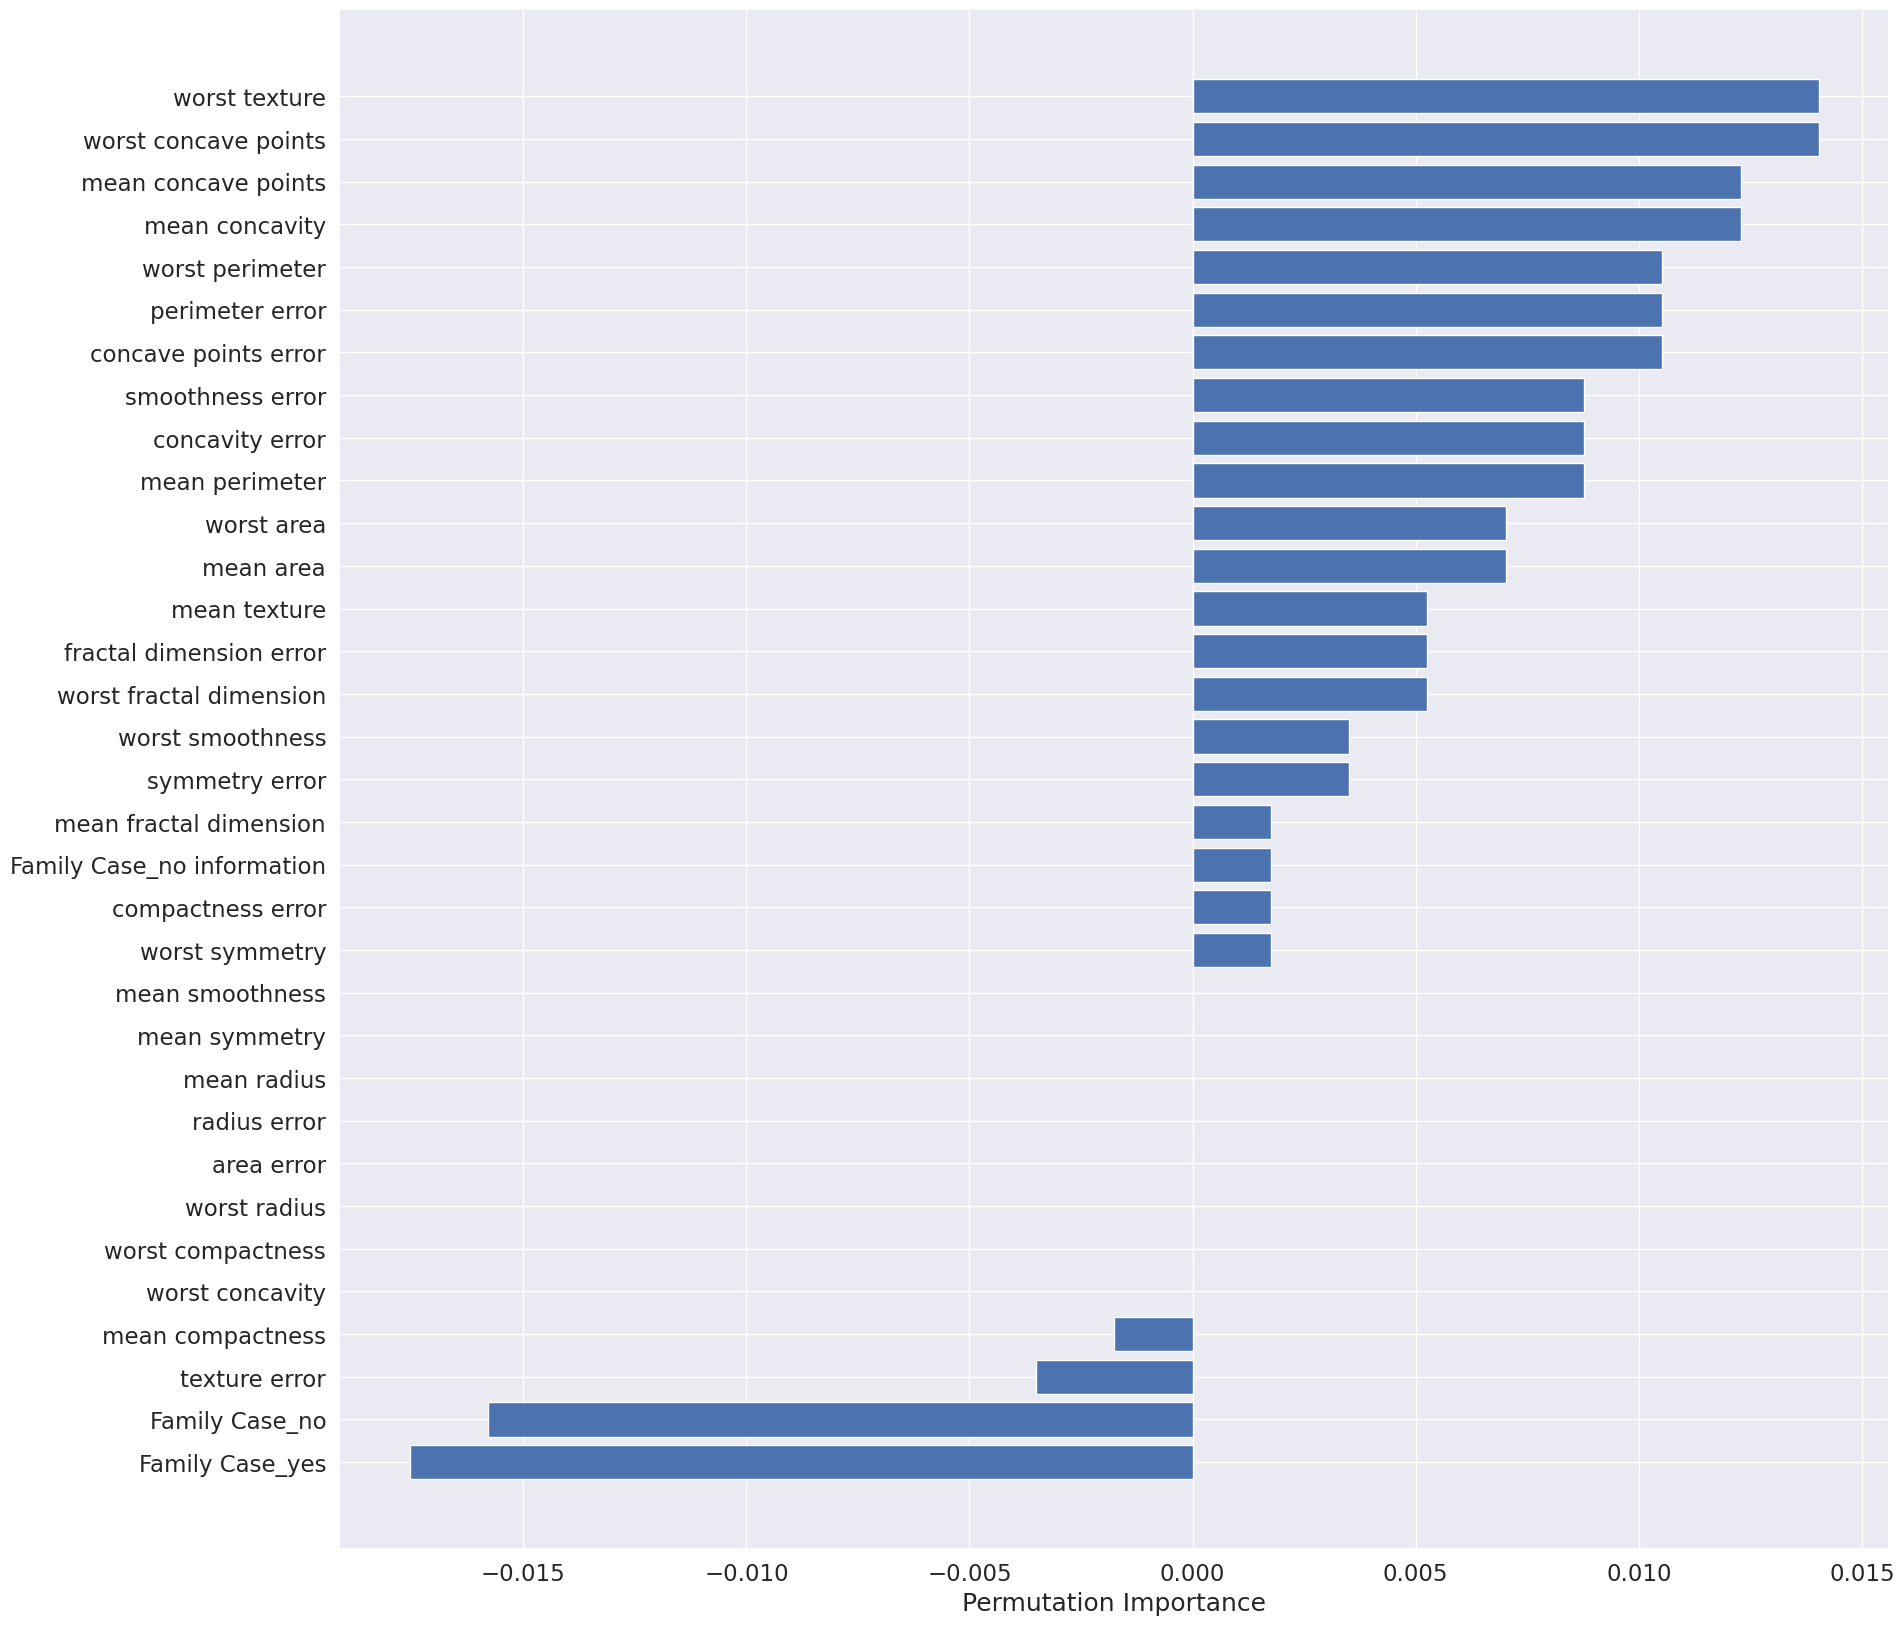

In [ ]:
probs = np.round(svm_f.predict_proba(Xtest)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytest, probs)
#Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
#This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
print('KS de Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))

probs = np.round(svm_f.predict_proba(Xtrain)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytrain, probs)
print('KS de Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))

#I can check the variables that were most relevant within my model
perm_importance = permutation_importance(svm_f, Xtest, ytest)

feature_names = Lista_variaveis
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [ ]:
#Final Base
X2 = padroniza.inverse_transform(X)
df1a = pd.DataFrame(data=X2, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=knn_f.predict(X2),columns=['Pred'])
df1a = pd.concat([df1a,df2,df3],axis=1)
df1a

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Family Case_no,Family Case_no information,Family Case_yes,Tarq,Pred
0,17.990000,10.380000,122.800000,1001.0,0.118400,0.27760,0.30010,0.14710,0.2419,0.07871,1095.0000,0.9053,8589.0,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.16220,0.66560,7.119000e-01,0.2654,0.4601,0.11890,1.110223e-16,0.0,1.0,0,0
1,20.570000,17.770000,132.900000,1326.0,0.096259,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3398.0,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.12380,0.18660,2.416000e-01,0.1860,0.2750,0.08902,1.110223e-16,0.0,1.0,0,0
2,711.656867,21.250000,130.000000,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4585.0,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.14440,0.42450,4.504000e-01,0.2430,0.3613,0.08758,1.110223e-16,0.0,1.0,0,0
3,11.420000,19.291343,77.580000,386.1,0.096259,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1156.0000,3445.0,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.20980,0.86630,6.869000e-01,0.2575,0.6638,0.17300,1.110223e-16,0.0,1.0,0,0
4,20.290000,14.340000,91.869399,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5438.0,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.13740,0.20500,4.000000e-01,0.1625,0.2364,0.07678,1.110223e-16,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.560000,22.390000,142.000000,1479.0,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,1176.0000,1256.0000,7673.0,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,166.10,2027.0,0.14100,0.21130,4.107000e-01,0.2216,0.2060,0.07115,1.110223e-16,1.0,0.0,0,0
565,20.130000,28.250000,131.200000,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2463.0000,5203.0,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.11660,0.19220,3.215000e-01,0.1628,0.2572,0.06637,1.110223e-16,1.0,0.0,0,0
566,16.600000,28.080000,108.300000,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1075.0000,3425.0,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.98,34.12,126.70,1124.0,0.11390,0.30940,3.403000e-01,0.1418,0.2218,0.07820,1.110223e-16,1.0,0.0,0,0
567,20.600000,29.330000,140.100000,1265.0,0.117800,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1595.0000,5772.0,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.74,39.42,184.60,1821.0,0.16500,0.86810,9.387000e-01,0.2650,0.4087,0.12400,1.110223e-16,1.0,0.0,0,0


Best Parameters {'max_iter': 150, 'solver': 'saga'}

Mean: 97.37
Standard Deviation: 0.00


<Axes: ylabel='Feature'>

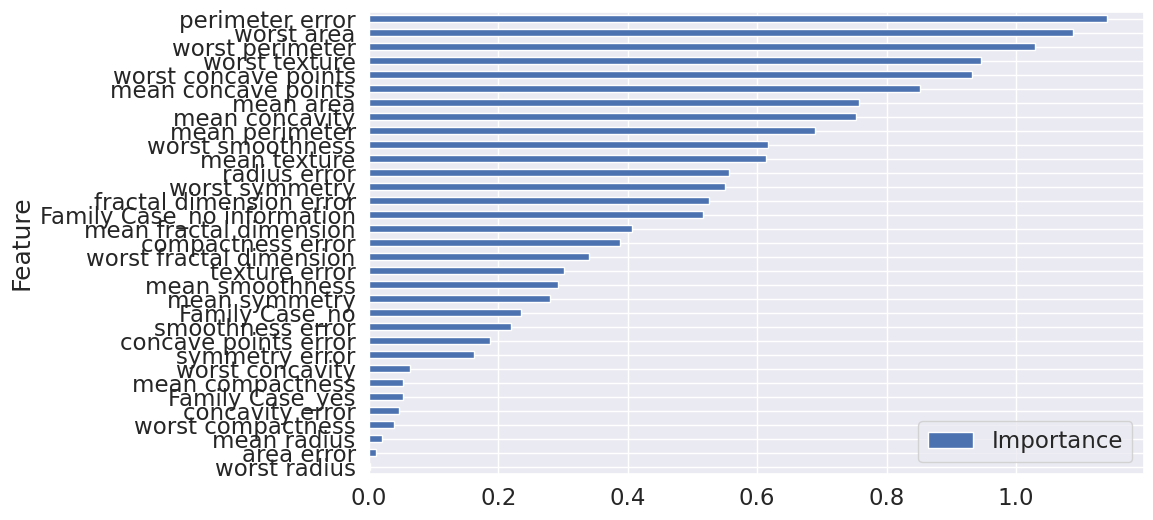

In [ ]:
#MODEL LOGISTIC REGRESSION
log_para=[{'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],'max_iter':[10,20,50,100,150,200]}]

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
log = GridSearchCV(LogisticRegression(), log_para, cv=3)
 # Convert ytrain and ytest to integer labels before fitting
ytrain = ytrain.astype(int) # Convert to integer type to avoid "unknown label type" error.
ytest = ytest.astype(int) # Convert to integer type to avoid "unknown label type" error.

log.fit(Xtrain,ytrain)
print('Best Parameters',log.best_params_)

DTArray = []
for i in range(0, 10):

     Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
     #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
     log_f = LogisticRegression(solver=log.best_params_['solver'],max_iter=log.best_params_['max_iter'])
     # Convert ytrain and ytest to integer labels before fitting
     ytrain = ytrain.astype(int) # Convert to integer type to avoid "unknown label type" error.
     ytest = ytest.astype(int) # Convert to integer type to avoid "unknown label type" error.

     log_f.fit(Xtrain, ytrain)

     ypred=log_f.predict(Xtest)
     cmDT=evaluateModel(ypred, ytest)
     DTArray.append(getAccuracy(cmDT))
print("\nMean: %.2f" % np.mean(DTArray))
print("Standard Deviation: %.2f" % np.std(DTArray))

#I can check the variables that were most relevant within my model
coefficients = log_f.coef_[0]

feature_importance = pd.DataFrame({'Feature': Lista_variaveis, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
probs = np.round(log_f.predict_proba(Xtest)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytest, probs)
#Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
#This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
print('KS de Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))

probs = np.round(log_f.predict_proba(Xtrain)[:,1], 7)
fpr, tpr, thresholds = roc_curve(ytrain, probs)
print('KS de Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
print((probs.max(),probs.min()))

KS de Validation: 66.67% e AUC: 99.75%
(0.9999999, 0.0)
KS de Development: 68.18% e AUC: 99.59%
(0.9999998, 0.0)


In [ ]:
X3 = padroniza.inverse_transform(X)
dfib = pd.DataFrame(data=X3, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=log_f.predict(X),columns=['Pred'])
dfib = pd.concat([dfib,df2,df3],axis=1)
dfib

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Family Case_no,Family Case_no information,Family Case_yes,Tarq,Pred
0,17.990000,10.380000,122.800000,1001.0,0.118400,0.27760,0.30010,0.14710,0.2419,0.07871,1095.0000,0.9053,8589.0,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.16220,0.66560,7.119000e-01,0.2654,0.4601,0.11890,1.110223e-16,0.0,1.0,0,0
1,20.570000,17.770000,132.900000,1326.0,0.096259,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3398.0,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.12380,0.18660,2.416000e-01,0.1860,0.2750,0.08902,1.110223e-16,0.0,1.0,0,0
2,711.656867,21.250000,130.000000,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4585.0,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.14440,0.42450,4.504000e-01,0.2430,0.3613,0.08758,1.110223e-16,0.0,1.0,0,0
3,11.420000,19.291343,77.580000,386.1,0.096259,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1156.0000,3445.0,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.20980,0.86630,6.869000e-01,0.2575,0.6638,0.17300,1.110223e-16,0.0,1.0,0,0
4,20.290000,14.340000,91.869399,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5438.0,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.13740,0.20500,4.000000e-01,0.1625,0.2364,0.07678,1.110223e-16,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.560000,22.390000,142.000000,1479.0,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,1176.0000,1256.0000,7673.0,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,166.10,2027.0,0.14100,0.21130,4.107000e-01,0.2216,0.2060,0.07115,1.110223e-16,1.0,0.0,0,0
565,20.130000,28.250000,131.200000,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2463.0000,5203.0,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.11660,0.19220,3.215000e-01,0.1628,0.2572,0.06637,1.110223e-16,1.0,0.0,0,0
566,16.600000,28.080000,108.300000,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1075.0000,3425.0,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.98,34.12,126.70,1124.0,0.11390,0.30940,3.403000e-01,0.1418,0.2218,0.07820,1.110223e-16,1.0,0.0,0,0
567,20.600000,29.330000,140.100000,1265.0,0.117800,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1595.0000,5772.0,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.74,39.42,184.60,1821.0,0.16500,0.86810,9.387000e-01,0.2650,0.4087,0.12400,1.110223e-16,1.0,0.0,0,0


In [ ]:
#Steps that could be added:

#- Based on the correlation of variables and the import feature,
#variables that may be less useful in the model could be removed,
#testing several times to eventually have a more consistent set of parameters and variables.